## BTC-USD Time Series Analysis


https://www.machinelearningplus.com/time-series/time-series-analysis-python/


Time series is a sequence of observations recorded at regular time intervals (hourly, daily, weekly, monthly, quarterly).
We analyze time series because it is the preparatory step before you develop a forecast.


Here we do a practical guide but i wish to a bit on the theoretical part afterwards

In [104]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

### Import the Time Series

In [105]:
df = pd.read_csv("C:/Users/SolalDanan/Trading Signal/1years_ohlcv_btc_usd_spot_1HRS.csv", parse_dates=['time_period_end'])
df

,id,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,1,2023-03-01 00:00:00+00:00,2023-03-01 01:00:00+00:00,2023-03-01 00:00:00.689833+00:00,2023-03-01 00:59:59.555883+00:00,23144.37,23221.87,23025.17,23103.31,403.085608,15524
1,2,2023-03-01 01:00:00+00:00,2023-03-01 02:00:00+00:00,2023-03-01 01:00:00.049205+00:00,2023-03-01 01:59:58.845876+00:00,23103.30,23299.98,23077.00,23253.04,417.658131,12504
2,3,2023-03-01 02:00:00+00:00,2023-03-01 03:00:00+00:00,2023-03-01 02:00:00.875321+00:00,2023-03-01 02:59:59.826664+00:00,23250.52,23338.00,23239.47,23333.54,196.964090,9236
3,4,2023-03-01 03:00:00+00:00,2023-03-01 04:00:00+00:00,2023-03-01 03:00:00.344045+00:00,2023-03-01 03:59:59.774815+00:00,23333.53,23496.14,23310.00,23443.06,509.948926,15547
4,5,2023-03-01 04:00:00+00:00,2023-03-01 05:00:00+00:00,2023-03-01 04:00:00.676182+00:00,2023-03-01 04:59:59.165328+00:00,23443.07,23850.00,23433.95,23788.52,656.431197,17865
...,...,...,...,...,...,...,...,...,...,...,...
10701,10702,2024-05-26 19:00:00+00:00,2024-05-26 20:00:00+00:00,2024-05-26 19:00:00.896316+00:00,2024-05-26 19:59:58.567234+00:00,68760.89,68884.55,68757.68,68864.96,52.297072,7757
10702,10703,2024-05-26 20:00:00+00:00,2024-05-26 21:00:00+00:00,2024-05-26 20:00:00.110404+00:00,2024-05-26 20:59:58.219726+00:00,68866.83,68873.02,68660.02,68680.91,72.434682,8461
10703,10704,2024-05-26 21:00:00+00:00,2024-05-26 22:00:00+00:00,2024-05-26 21:00:00.756994+00:00,2024-05-26 21:59:58.536776+00:00,68680.91,68680.91,68097.38,68495.63,215.694964,12007
10704,10705,2024-05-26 22:00:00+00:00,2024-05-26 23:00:00+00:00,2024-05-26 22:00:00.043714+00:00,2024-05-26 22:59:59.711489+00:00,68495.63,68682.44,68431.37,68526.05,193.505300,9395


In [106]:
def fill_gaps_with_interpolation(df, col, expected_freq):
    """
    Fills gaps in the DataFrame using linear interpolation, based on the expected frequency.
    Ensures 'time_period_start' is in datetime format and 'id' is the index.

    Parameters:
        df (pd.DataFrame): The DataFrame to be interpolated.
        expected_freq (str): The frequency string indicating the expected interval between rows.

    Returns:
        pd.DataFrame: The interpolated DataFrame with gaps filled.
    """
    df[col] = pd.to_datetime(df[col], utc=True)
    df_temp = df.set_index(col)
    expected_freq = expected_freq.replace('HRS', 'h').replace('MIN', 'min')
    full_index = pd.date_range(start=df_temp.index.min(), end=df_temp.index.max(), freq=expected_freq)
    df_reindexed = df_temp.reindex(full_index)
    df_reindexed['is_interpolated'] = df_reindexed.isna().any(axis=1)
    df_interpolated = df_reindexed.interpolate(method='linear')
    df_interpolated.reset_index(inplace=True)
    df_interpolated.rename(columns={'index': col}, inplace=True)

    return df_interpolated

In [107]:
df = pd.read_csv("C:/Users/SolalDanan/Trading Signal/1years_ohlcv_btc_usd_spot_1HRS.csv", parse_dates=['time_period_end'])
df = fill_gaps_with_interpolation(df, 'time_period_end', '1HRS')
df = df[['time_period_end', 'price_close']].rename(columns={'time_period_end': 'date', 'price_close': 'value'})
df['date'] = df['date'].dt.tz_convert(None)
# Set the 'date' column as the index
df.set_index('date', inplace=True)
df

C:\Users\SolalDanan\AppData\Local\Temp\ipykernel_20416\3005932370.py:19: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpolated = df_reindexed.interpolate(method='linear')


,value
date,
2023-03-01 01:00:00,23103.31
2023-03-01 02:00:00,23253.04
2023-03-01 03:00:00,23333.54
2023-03-01 04:00:00,23443.06
2023-03-01 05:00:00,23788.52
...,...
2024-05-26 20:00:00,68864.96
2024-05-26 21:00:00,68680.91
2024-05-26 22:00:00,68495.63


### Visualizing a time series

In [108]:
# Check for missing values
print("Missing values before filling:")
print(df.isnull().sum())

Missing values before filling:
value    0
dtype: int64


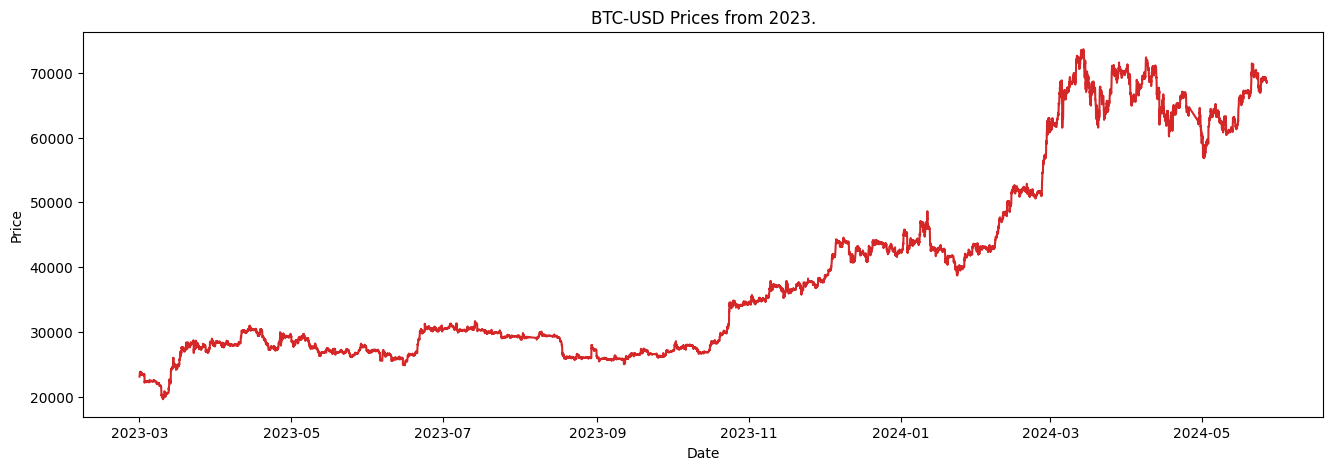

In [109]:
# Draw Plot
def plot_df(x, y, title="", xlabel='Date', ylabel='Price', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(x=df.index, y=df['value'], title='BTC-USD Prices from 2023.')    

Since all values are positive, you can show this on both sides of the Y axis to emphasize the growth.

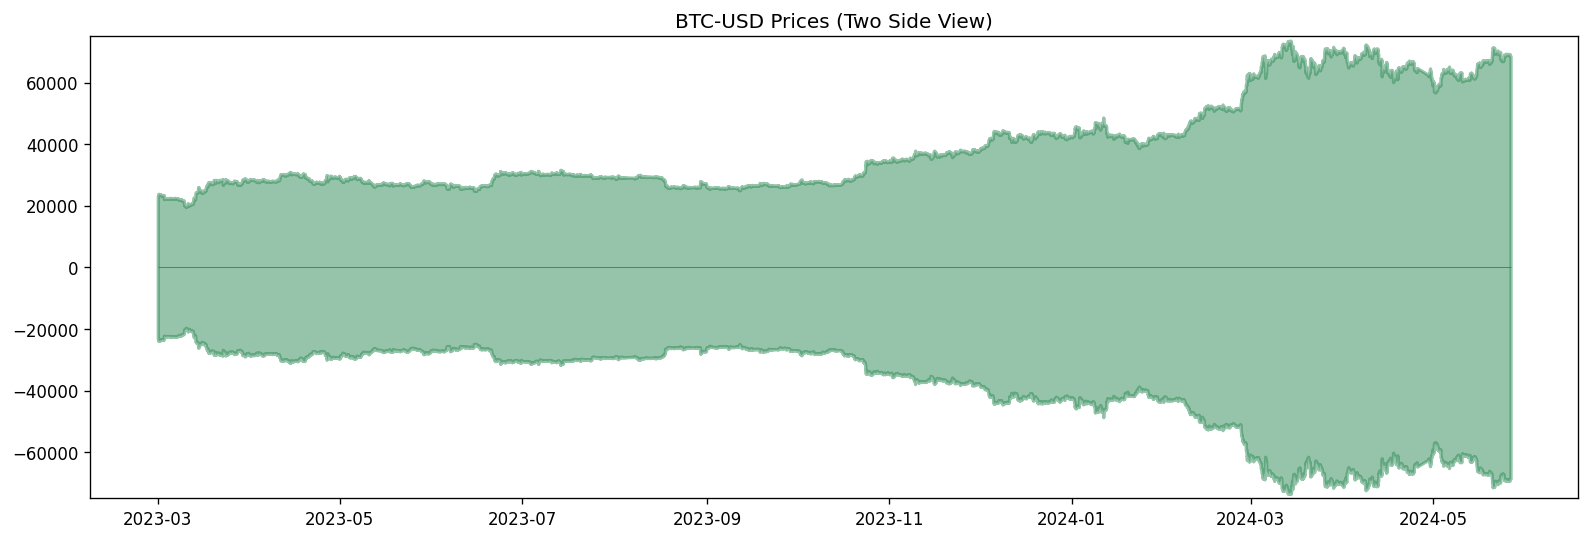

In [110]:
x = df.index
y1 = df['value'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-75000, 75000)
plt.title('BTC-USD Prices (Two Side View)', fontsize=12)
plt.hlines(y=0, xmin=np.min(df.index), xmax=np.max(df.index), linewidth=.5)
plt.show()

 We can plot each month as a separate line in the same plot. This lets you compare the monthly wise patterns side-by-side.

C:\Users\SolalDanan\AppData\Local\Temp\ipykernel_20416\3005932370.py:19: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpolated = df_reindexed.interpolate(method='linear')


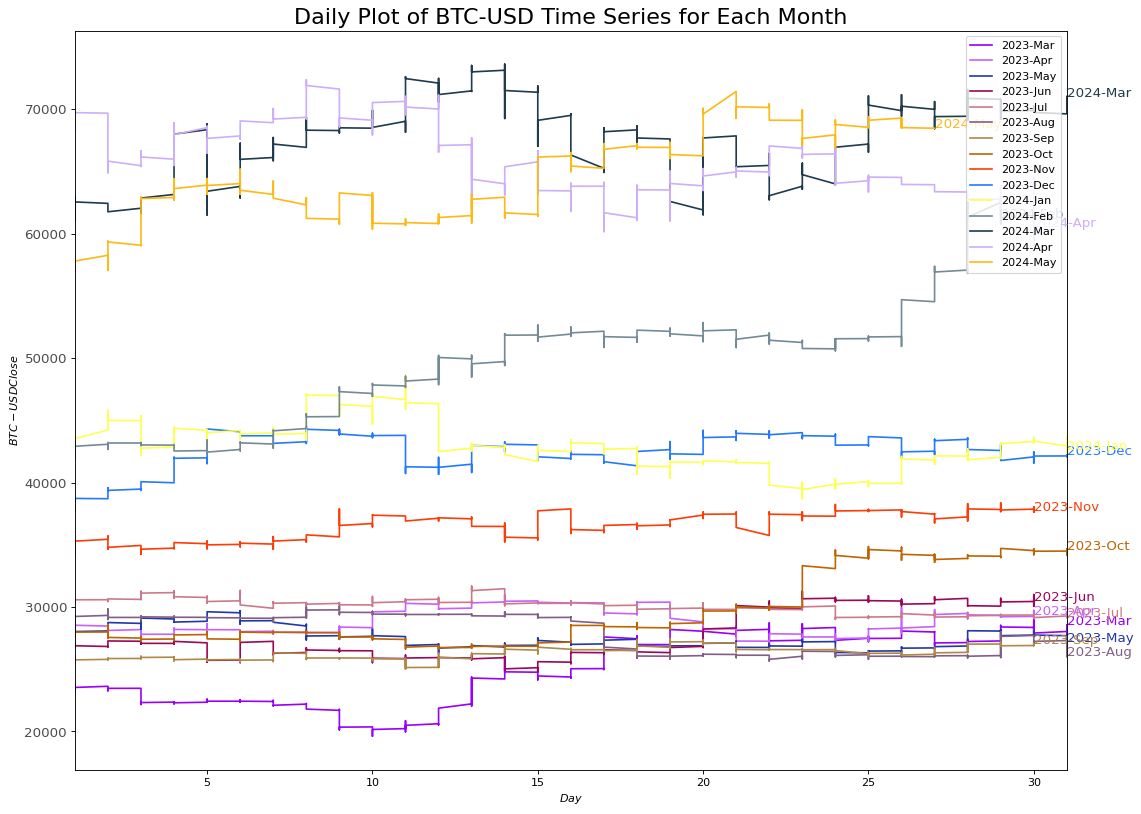

In [111]:
df2 = pd.read_csv("C:/Users/SolalDanan/Trading Signal/1years_ohlcv_btc_usd_spot_1HRS.csv", parse_dates=['time_period_end'])
df2 = fill_gaps_with_interpolation(df2, "time_period_end",'1HRS')
df2 = df2[['time_period_end', 'price_close']].rename(columns={'time_period_end': 'date', 'price_close': 'value'})
df2['date'] = pd.to_datetime(df2['date'])

# Prepare data by creating 'year', 'month', and 'day' columns
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.strftime('%b')
df2['day'] = df2['date'].dt.day
df2['year_month'] = df2['date'].dt.strftime('%Y-%b')  # Combine year and month for unique labels

# Prep Colors
np.random.seed(100)
year_months = df2['year_month'].unique()
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(year_months), replace=False)

# Draw Plot
plt.figure(figsize=(16, 12), dpi=80)
for i, ym in enumerate(year_months):
    monthly_data = df2[df2['year_month'] == ym]
    plt.plot(monthly_data['day'], monthly_data['value'], color=mycolors[i], label=ym)
    plt.text(monthly_data['day'].iloc[-1], monthly_data['value'].iloc[-1], ym, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(xlim=(1, 31), ylabel='$BTC-USD Close$', xlabel='$Day$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Daily Plot of BTC-USD Time Series for Each Month", fontsize=20)
plt.legend()
plt.show()


**Observations and Explanations:**

Non-Smooth Lines (Jumps): The lines show jumps and are not smooth, which is common in financial time series data due to:
- Market Volatility: Bitcoin is known for its high volatility, with prices often fluctuating significantly from one day to the next.
- Data Gaps: If there were missing data points in the dataset, the lines might jump from one price to another without intermediate values. This can be mitigated by filling missing values (as suggested in the previous explanation).

**Distinct Monthly Patterns:**

Seasonal Trends: Each month may exhibit different trends. For instance, certain months might show an upward trend while others might show a downward trend or stagnation. This can be due to various market factors, news events, or seasonal trading behaviors.
Comparison Across Months: The plot allows for a visual comparison across different months and years. For example, the line for December 2023 is relatively more stable compared to March 2023, which shows more fluctuations.

C:\Users\SolalDanan\AppData\Local\Temp\ipykernel_20416\3005932370.py:19: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpolated = df_reindexed.interpolate(method='linear')


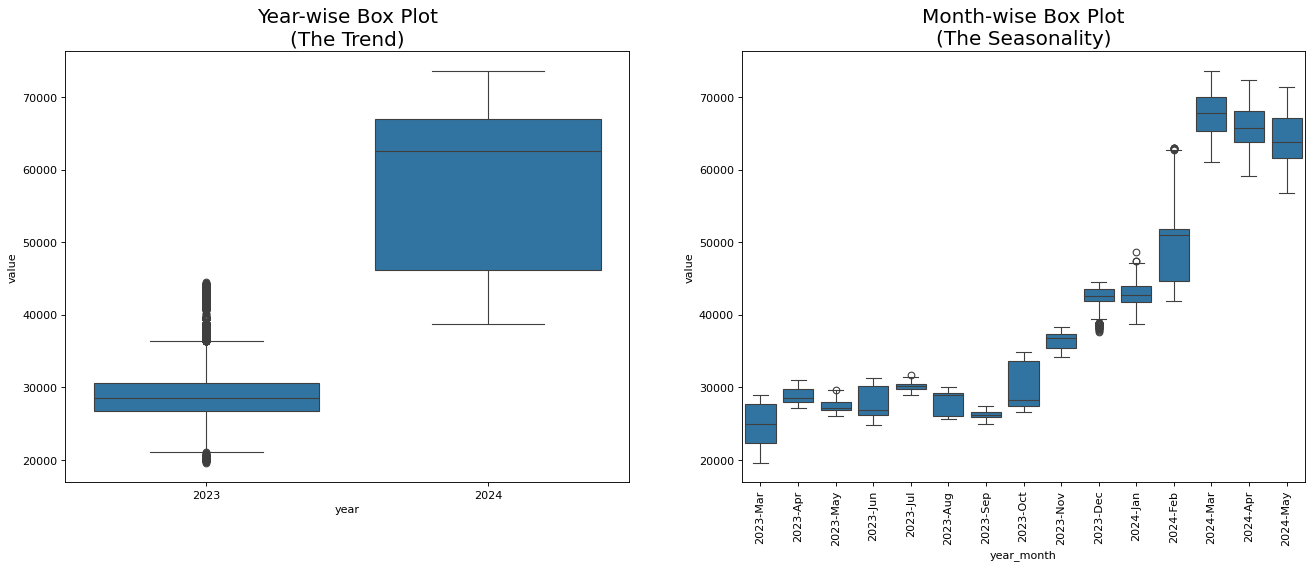

In [112]:
df3 = pd.read_csv("C:/Users/SolalDanan/Trading Signal/1years_ohlcv_btc_usd_spot_1HRS.csv", parse_dates=['time_period_end'])
df3 = fill_gaps_with_interpolation(df3, 'time_period_end' ,'1HRS')
df3 = df3[['time_period_end', 'price_close']].rename(columns={'time_period_end': 'date', 'price_close': 'value'})
df3.reset_index(inplace=True)

# Ensure the 'date' column is in datetime format if it's not already
df3['date'] = pd.to_datetime(df3['date'])

# Prepare data by creating 'year', 'month', and 'year_month' columns
df3['year'] = df3['date'].dt.year
df3['month'] = df3['date'].dt.strftime('%b')
df3['year_month'] = df3['date'].dt.strftime('%Y-%b')  # Combine year and month for unique labels

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 7), dpi=80)
sns.boxplot(x='year', y='value', data=df3, ax=axes[0])
sns.boxplot(x='year_month', y='value', data=df3, ax=axes[1])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18)
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better readability

plt.show()

The monthly box plot shows clear seasonality with a significant upward trend beginning in early 2024.
The increasing median values each month in 2024 align with the trend observed in the year-wise box plot.
The increased variability in the early months of 2024 suggests a period of adjustment or transition, possibly due to external factors influencing the data. It represents a high volatiility periods.

## Patterns in a time series
Any time series may be split into the following components: **Base Level - Trend - Seasonality - Error**

A trend is observed when there is an increasing or decreasing slope observed in the time series. Whereas seasonality is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors. It could be because of the month of the year, the day of the month, weekdays or even time of the day.

However, It is not mandatory that all time series must have a trend and/or seasonality. A time series may not have a distinct trend but have a seasonality. The opposite can also be true.

Another aspect to consider is the cyclic behaviour. It happens when the rise and fall pattern in the series does not happen in fixed calendar-based intervals. Care should be taken to not confuse ‘cyclic’ effect with ‘seasonal’ effect.

So, How to diffentiate between a ‘cyclic’ vs ‘seasonal’ pattern?

If the patterns are not of fixed calendar based frequencies, then it is cyclic. Because, unlike the seasonality, cyclic effects are typically influenced by the business and other socio-economic factors.

## Additive and multiplicative time series
Depending on the nature of the trend and seasonality, a time series can be modeled as an additive or multiplicative

Additive time series:
Value = Base Level + Trend + Seasonality + Error

Multiplicative Time Series:
Value = Base Level x Trend x Seasonality x Error

**Time Series Components Decomposition**

You can do a classical decomposition of a time series by considering the series as an additive or multiplicative combination of the base level, trend, seasonal index and the residual.

C:\Users\SolalDanan\AppData\Local\Temp\ipykernel_20416\3005932370.py:19: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpolated = df_reindexed.interpolate(method='linear')
C:\Users\SolalDanan\AppData\Local\Temp\ipykernel_20416\2487772730.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq('1H')  # Confirming frequency setting


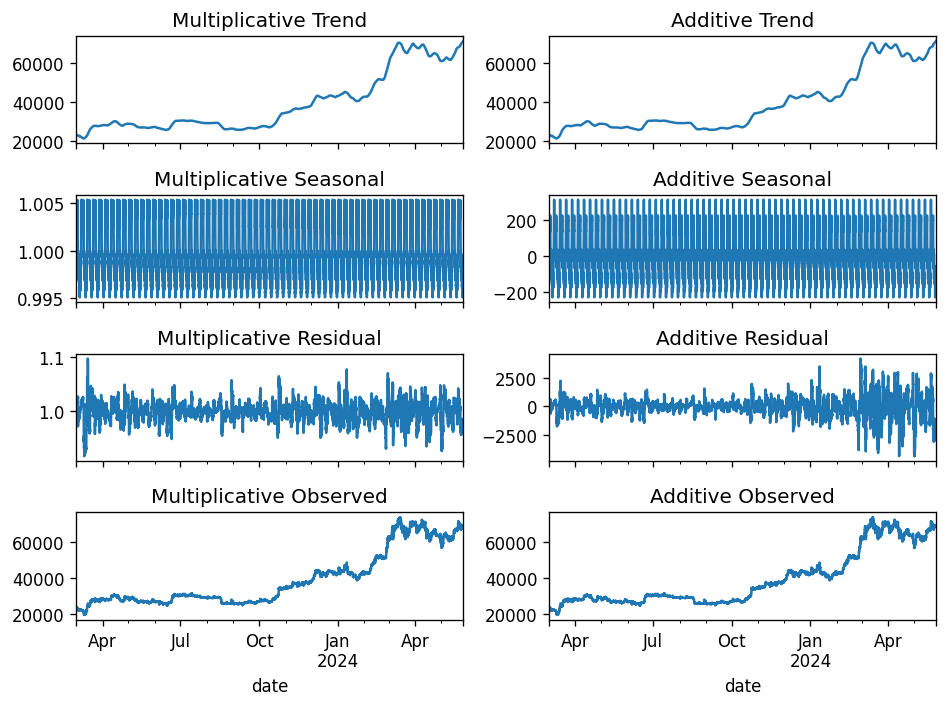

In [113]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

# Load and prepare the data
df = pd.read_csv("C:/Users/SolalDanan/Trading Signal/1years_ohlcv_btc_usd_spot_1HRS.csv", parse_dates=['time_period_end'])
df = fill_gaps_with_interpolation(df, 'time_period_end', '1HRS')
df = df[['time_period_end', 'price_close']].rename(columns={'time_period_end': 'date', 'price_close': 'value'})
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.asfreq('1H')  # Confirming frequency setting

# Decomposition
# Try using a weekly period (168 hours)
periods_per_day = 168
result_mul = seasonal_decompose(df['value'].dropna(), model='multiplicative', extrapolate_trend='freq', period=periods_per_day)
result_add = seasonal_decompose(df['value'].dropna(), model='additive', extrapolate_trend='freq', period=periods_per_day)

# Plotting manually
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 6), sharex=True)

# Multiplicative
result_mul.trend.plot(ax=axes[0, 0], title='Multiplicative Trend')
result_mul.seasonal.plot(ax=axes[1, 0], title='Multiplicative Seasonal')
result_mul.resid.plot(ax=axes[2, 0], title='Multiplicative Residual')
result_mul.observed.plot(ax=axes[3, 0], title='Multiplicative Observed')

# Additive
result_add.trend.plot(ax=axes[0, 1], title='Additive Trend')
result_add.seasonal.plot(ax=axes[1, 1], title='Additive Seasonal')
result_add.resid.plot(ax=axes[2, 1], title='Additive Residual')
result_add.observed.plot(ax=axes[3, 1], title='Additive Observed')

plt.tight_layout()

plt.show()


In [114]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
date,,,,
2023-03-01 01:00:00+00:00,1.003326,23231.539481,0.991183,23103.31
2023-03-01 02:00:00+00:00,1.003072,23223.387798,0.998211,23253.04
2023-03-01 03:00:00+00:00,1.002275,23215.236115,1.002815,23333.54
2023-03-01 04:00:00+00:00,1.001556,23207.084432,1.008599,23443.06
2023-03-01 05:00:00+00:00,1.002658,23198.932749,1.022696,23788.52


A priori pas de saison

<Figure size 480x360 with 0 Axes>

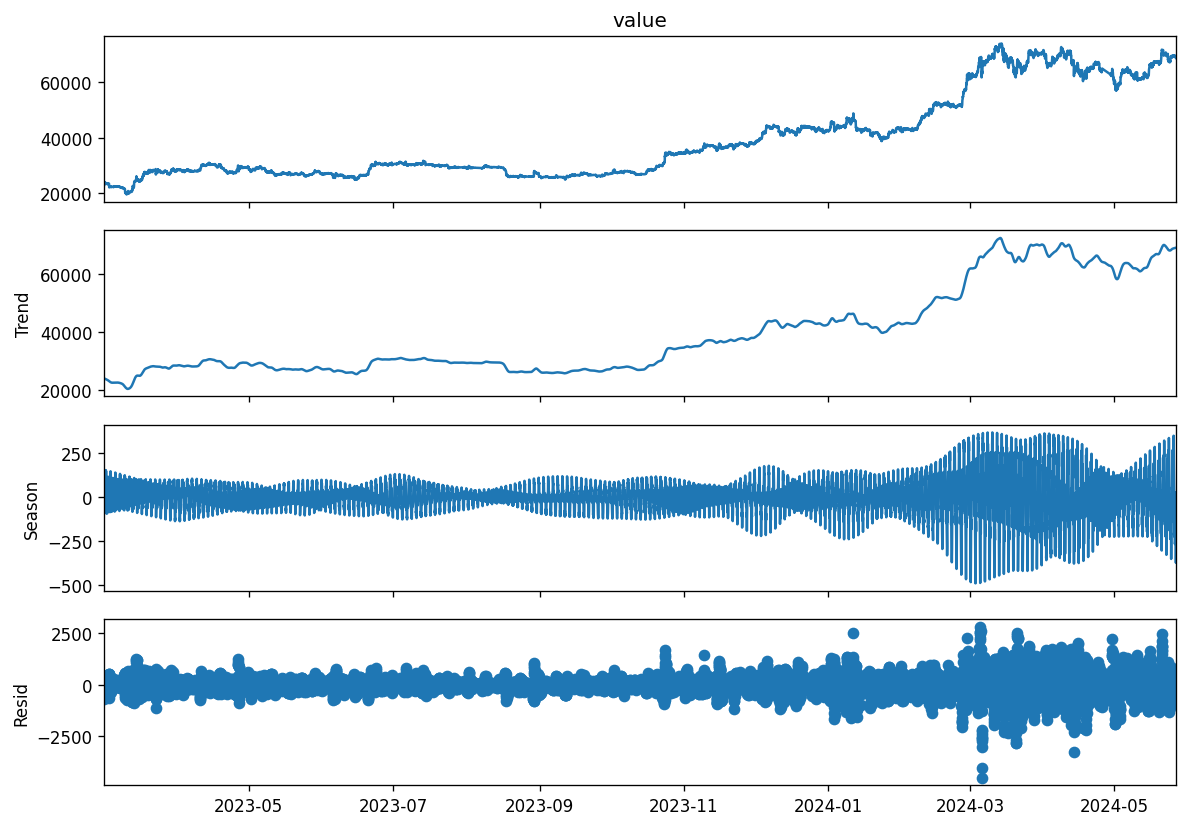

In [115]:
from statsmodels.tsa.seasonal import STL

# Try using a weekly period (168 hours)
periods_per_week = 48
# Using STL for a potentially more robust decomposition
stl = STL(df['value'].dropna(), seasonal=31, period=periods_per_week)
result_stl = stl.fit()

plt.figure(figsize=(4, 3))
result_stl.plot()
plt.tight_layout()

Trend Recognition: Both methods identify the upward trend, but STL provides a smoother and possibly more insightful representation of the trend component.

Seasonal Detection: STL detects more detailed seasonal patterns, which are not evident in the classical decomposition's seasonal plots. This could be crucial for understanding underlying cyclical behaviors that are not simply yearly but perhaps of different frequencies.

Residual Analysis: Residuals from STL are cleaner, implying that it captures the data's structure more effectively, leaving less structured noise in the residuals. This can be particularly useful for identifying outliers or anomalies.

## Stationary and Non-Stationary Time Series

Stationarity is a property of a time series. 
#### A stationary series is one where the values of the series is not a function of time.

That is, the statistical properties of the series like mean, variance and autocorrelation are constant over time. 
Autocorrelation of the series is nothing but the correlation of the series with its previous values, more on this coming up.

Forecasting a stationary series is relatively easy and the forecasts are more reliable.

It is possible to make nearly any time series stationary by applying a suitable transformation. Most statistical forecasting methods are designed to work on a stationary time series. The first step in the forecasting process is typically to do some transformation to convert a non-stationary series to stationary.
An important reason is, autoregressive forecasting models are essentially linear regression models that utilize the lag(s) of the series itself as predictors.
We know that linear regression works best if the predictors (X variables) are not correlated against each other. So, stationarizing the series solves this problem since it removes any persistent autocorrelation, thereby making the predictors (lags of the series) in the forecasting models nearly independent.

### How to test for stationarity?

The stationarity of a series can be established by looking at the plot of the series like we did earlier.
Another method is to split the series into 2 or more contiguous parts and computing the summary statistics like the mean, variance and the autocorrelation. If the stats are quite different, then the series is not likely to be stationary.


**Nevertheless, a method to quantitatively determine if a given series is stationary or not. This can be done using statistical tests called ‘Unit Root Tests’.** 

There are multiple variations of this, where the tests check if a time series is non-stationary and possess a unit root.

- Augmented Dickey Fuller test (ADH Test)
- Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
- Philips Perron test (PP Test)

The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, id the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis.


The KPSS test, on the other hand, is used to test for trend stationarity. The null hypothesis and the P-Value interpretation is just the opposite of ADH test. The below code implements these two tests using statsmodels package in python.

In [116]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(df.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df.value.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 0.14619001878013582
p-value: 0.9690768340116943
Critial Values:
   1%, -3.4309533993726915
Critial Values:
   5%, -2.8618066689050883
Critial Values:
   10%, -2.566911942724432

KPSS Statistic: 14.422817
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\SolalDanan\AppData\Local\Temp\ipykernel_20416\2570747489.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df.value.values, regression='c')


Both tests suggest that the time series data is non-stationary. The ADF test indicates the presence of a unit root, and the KPSS test also confirms non-stationarity by showing trends or non-constant variance in the data. This implies that some form of differencing, transformation, or detrending may be necessary to make the series stationary for further analysis, such as forecasting or modeling.

## What is the difference between white noise and a stationary series?

Like a stationary series, the white noise is also not a function of time, that is its mean and variance does not change over time. But the difference is, the white noise is completely random with a mean of 0.

In white noise there is no pattern whatsoever. If you consider the sound signals in an FM radio as a time series, the blank sound you hear between the channels is white noise.

Mathematically, a sequence of completely random numbers with mean zero is a white noise.


<Axes: title={'center': 'Random White Noise'}>

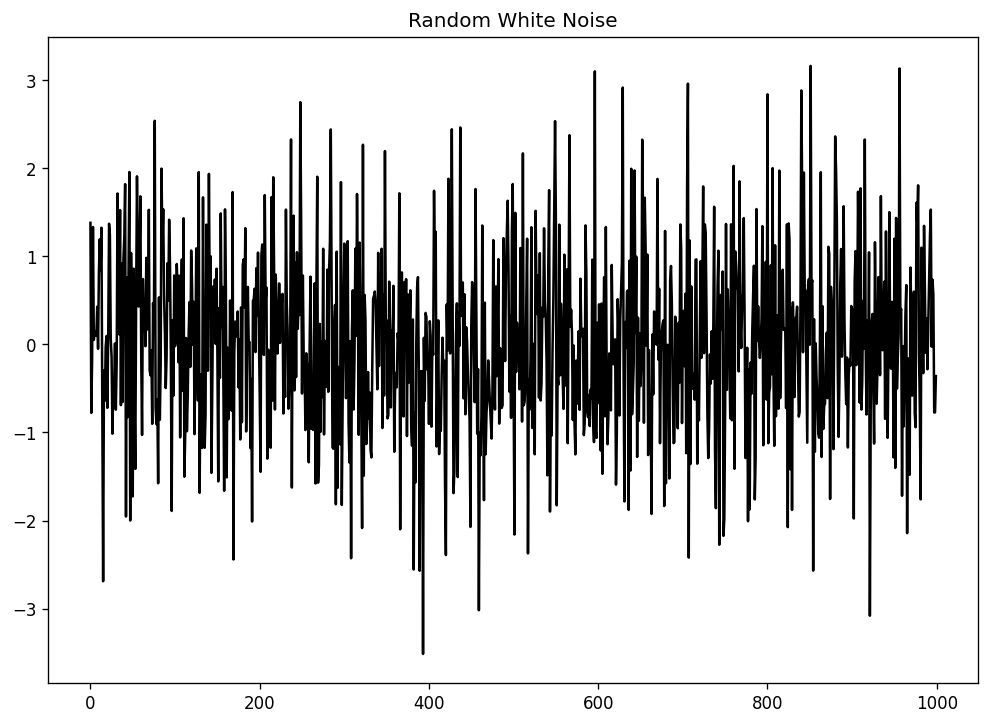

In [117]:
randvals = np.random.randn(1000)
pd.Series(randvals).plot(title='Random White Noise', color='k')

### Ljung-Box Test
The Ljung-Box test is commonly used to test whether any group of autocorrelations of a time series is different from zero. It tests the null hypothesis that the series is white noise.

In [118]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import q_stat

# Perform Ljung-Box test
ljung_box_result = acorr_ljungbox(df['value'], lags=[10], return_df=True)

print(ljung_box_result)

          lb_stat  lb_pvalue
10  108382.385957        0.0


## How to detrend a time series?
Detrending a time series is to remove the trend component from a time series. But how to extract the trend? There are multiple approaches.

- Subtract the line of best fit from the time series. The line of best fit may be obtained from a linear regression model with the time steps as the predictor. For more complex trends, you may want to use quadratic terms (x^2) in the model.
- Subtract the trend component obtained from time series decomposition we saw earlier.
- Subtract the mean
- Apply a filter like Baxter-King filter(statsmodels.tsa.filters.bkfilter) or the Hodrick-Prescott Filter (statsmodels.tsa.filters.hpfilter) to remove the moving average trend lines or the cyclical components.

Text(0.5, 1.0, 'BTC-USD Price detrended by subtracting the least squares fit')

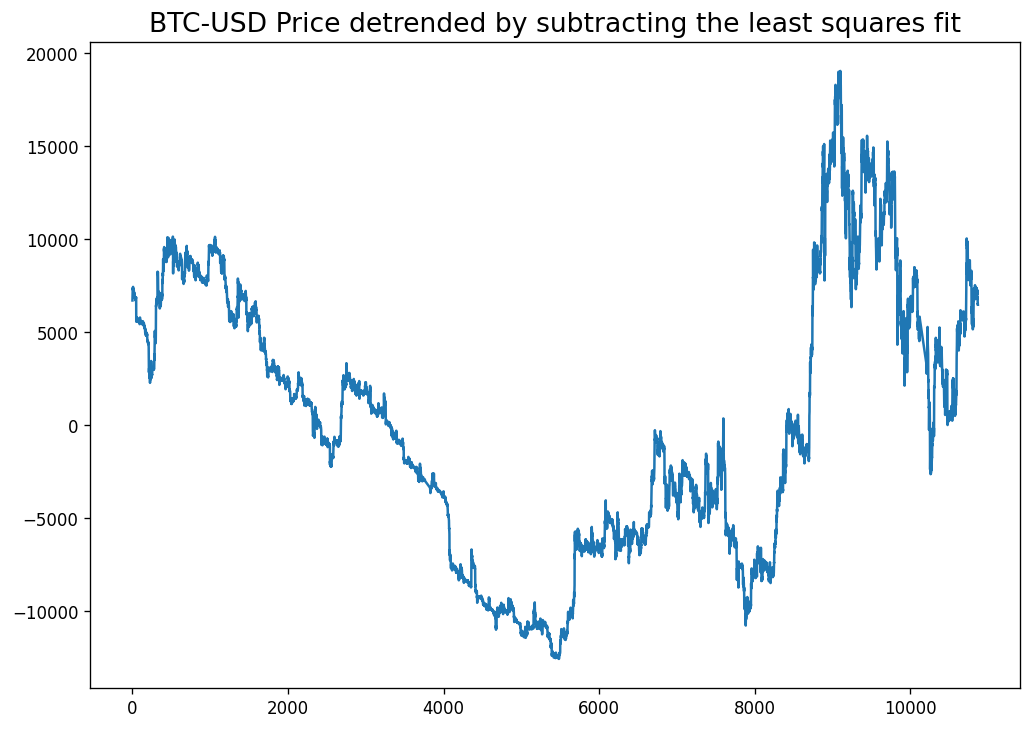

In [119]:
# Using scipy: Subtract the line of best fit
from scipy import signal

detrended = signal.detrend(df.value.values)
plt.plot(detrended)
plt.title('BTC-USD Price detrended by subtracting the least squares fit', fontsize=16)


Text(0.5, 1.0, 'BTC-USD Price detrended by subtracting the trend component')

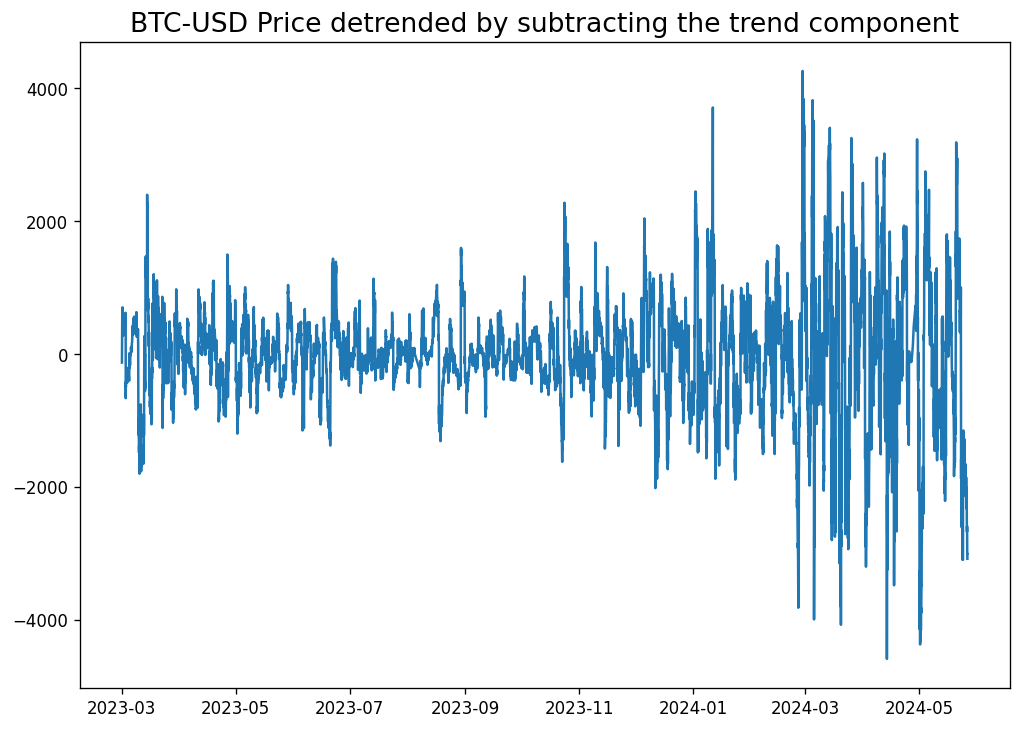

In [120]:
# Using statmodels: Subtracting the Trend Component.
from statsmodels.tsa.seasonal import seasonal_decompose

# result_add / result_stl / result_mul

detrended = df.value.values - result_mul.trend
plt.plot(detrended)
plt.title('BTC-USD Price detrended by subtracting the trend component', fontsize=16)

## How to deseasonalize a time series?
There are multiple approaches to deseasonalize a time series as well. Below are a few:

- 1. Take a moving average with length as the seasonal window. This will smoothen in series in the process.

- 2. Seasonal difference the series (subtract the value of previous season from the current value)

- 3. Divide the series by the seasonal index obtained from STL decomposition

[]

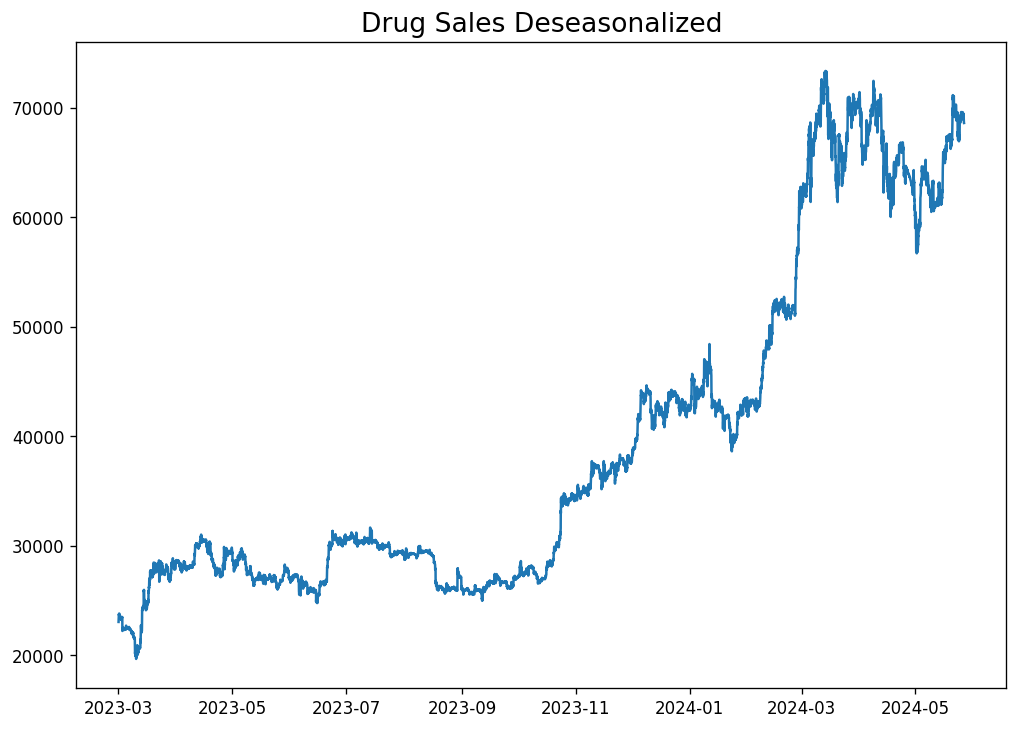

In [121]:
# Time Series Decomposition
# Using STL for a potentially more robust decomposition
stl = STL(df['value'].dropna(), seasonal=13, period=periods_per_week)  # adjust seasonal parameter as needed
result_stl = stl.fit()

# Deseasonalize
deseasonalized = df.value.values / result_mul.seasonal


# result_add / result_stl / result_mul
# Plot
plt.plot(deseasonalized)
plt.title('Drug Sales Deseasonalized', fontsize=16)
plt.plot()

## How to test for seasonality of a time series?
The common way is to plot the series and check for repeatable patterns in fixed time intervals. So, the types of seasonality is determined by the clock or the calendar: Hour of day/Day of month/Weekly/MonthlyYearly

However, if you want a more definitive inspection of the seasonality, use the Autocorrelation Function (ACF) plot. More on the ACF in the upcoming sections. But when there is a strong seasonal pattern, the ACF plot usually reveals definitive repeated spikes at the multiples of the seasonal window.

For example, the drug sales time series is a monthly series with patterns repeating every year. So, you can see spikes at 12th, 24th, 36th.. lines.

I must caution you that in real word datasets such strong patterns is hardly noticed and can get distorted by any noise, so you need a careful eye to capture these patterns.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

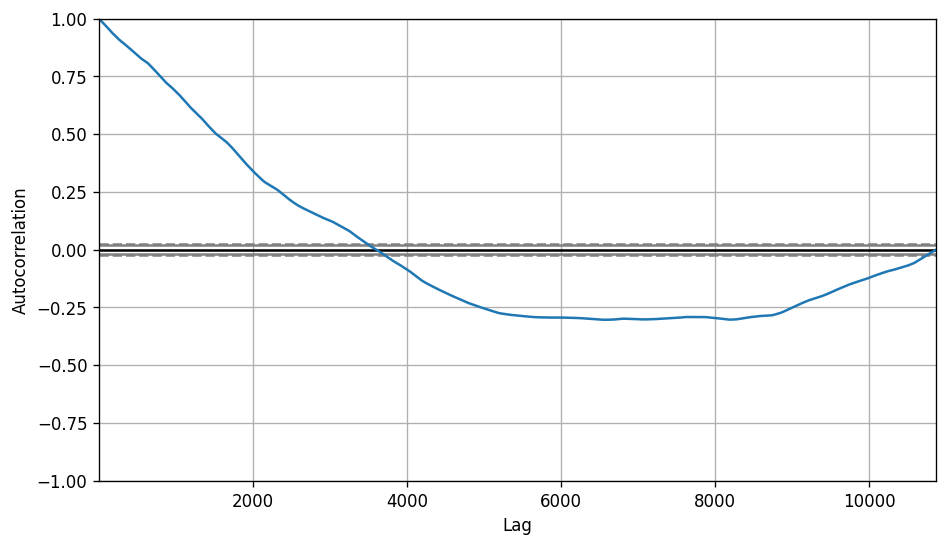

In [122]:
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df.value.tolist())

### Alternately, if you want a statistical test, the CHTest can determine if seasonal differencing is required to stationarize the series.

In [123]:
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Assuming monthly data, so we'll use a lag of 24 for seasonal differencing
seasonal_difference = df.value 
#- df.value.shift(24)

# Drop NaN values that result from differencing
seasonal_difference.dropna(inplace=True)

# Apply the ADF test on the seasonally differenced series
adf_result = adfuller(seasonal_difference)

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
for key, value in adf_result[4].items():
    print(f'Critical Values {key}: {value}')

# Interpret the ADF results
if adf_result[1] < 0.05:
    print("The seasonally differenced series is stationary.")
else:
    print("The seasonally differenced series is not stationary.")


ADF Statistic: 0.14619001878013582
p-value: 0.9690768340116943
Critical Values 1%: -3.4309533993726915
Critical Values 5%: -2.8618066689050883
Critical Values 10%: -2.566911942724432
The seasonally differenced series is not stationary.


If the p-value from the ADF test is less than 0.05, and the test statistic is lower than the critical values at a significant level (usually 1%, 5%, and 10%), the differenced data can be considered stationary.

When the results from an Augmented Dickey-Fuller (ADF) test on your time series data indicate that the series is stationary, this suggests that no further differencing (including seasonal differencing) is required to achieve stationarity. The purpose of using seasonal differencing is to remove seasonal patterns that could make a series appear non-stationary when these seasonal effects are actually predictable and repeating at fixed intervals.

### Here there is need seasonal differencing 

## How to treat missing values in a time series?
Sometimes, your time series will have missing dates/times. That means, the data was not captured or was not available for those periods. It could so happen the measurement was zero on those days, in which case, case you may fill up those periods with zero.

Secondly, when it comes to time series, you should typically NOT replace missing values with the mean of the series, especially if the series is not stationary. What you could do instead for a quick and dirty workaround is to forward-fill the previous value.

However, depending on the nature of the series, you want to try out multiple approaches before concluding. Some effective alternatives to imputation are:
- Backward Fill
- Forward Fill
- Linear Interpolation
- Quadratic interpolation
- Mean of nearest neighbors
- Mean of seasonal couterparts

To measure the imputation performance, I manually introduce missing values to the time series, impute it with above approaches and then measure the mean squared error of the imputed against the actual values.


You could also consider the following approaches depending on how accurate you want the imputations to be.
- If you have explanatory variables use a prediction model like the random forest or k-Nearest Neighbors to predict it.
- If you have enough past observations, forecast the missing values.
- If you have enough future observations, backcast the missing values


## What is autocorrelation and partial autocorrelation functions?

**Autocorrelation Function (ACF):**

**Autocorrelation, or serial correlation, describes the correlation of a time series with its own past and future values (lags).** Specifically, the autocorrelation function (ACF) measures how a series is correlated with itself over different time intervals (lags). This is fundamentally important in time series analysis because most time series models will incorporate terms to handle and describe these autocorrelations.

**If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.**

When you plot the ACF, it can help identify the type of time series model to use, such as an ARIMA model, by indicating how many past observations significantly influence the current one. For instance, if the ACF shows significant values at lags 1 and 2, but these correlations quickly diminish after that, a model that accounts for these specific lags might be appropriate.


**Partial Autocorrelation Function (PACF):**

While the autocorrelation function considers total correlation between a series and its lags, the partial autocorrelation function (PACF) offers a purer measure. PACF isolates the correlation between the series and a particular lag, say k, after removing the effects of correlations at shorter lags (1 through k−1). **This means the PACF tells you the direct effect of past values on the current value**, without the interference of correlations that are merely passed down through intermediate values.

The PACF is particularly useful in identifying the order of autoregressive terms in an AR model. For example, if the PACF shows a sharp cut-off after the first lag, an AR(1) model is typically a good fit. This means only the first lag is significantly correlated with the current value when the effects of all intermediate lags are removed.
Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

### Visualizing ACF and PACF

Both ACF and PACF are typically plotted as bar charts against the number of lags. These plots are crucial for the diagnostic phase of time series modeling:

- ACF Plot: Shows the correlation of the series with its lags over multiple time periods. Slow decay in the ACF plot indicates a non-stationary series, while a sharp drop might suggest a stationary one.
- PACF Plot: Illustrates the partial correlation with each lag. This plot helps determine the necessary lags for the autoregressive terms in an AR model, indicated by significant spikes at specific lags.

In [124]:
df = pd.read_csv("C:/Users/SolalDanan/Trading Signal/1years_ohlcv_btc_usd_spot_1HRS.csv", parse_dates=['time_period_end'])
df = fill_gaps_with_interpolation(df, 'time_period_end','1HRS')
df = df[['time_period_end', 'price_close']].rename(columns={'time_period_end': 'date', 'price_close': 'value'})


C:\Users\SolalDanan\AppData\Local\Temp\ipykernel_20416\3005932370.py:19: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpolated = df_reindexed.interpolate(method='linear')


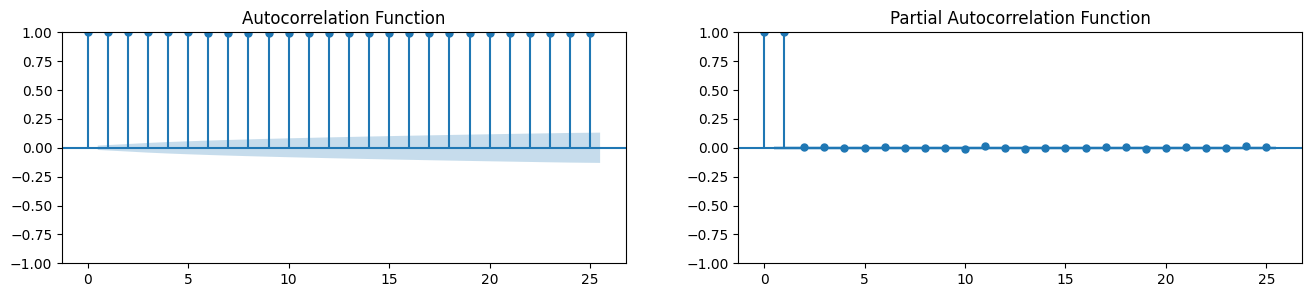

In [126]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting ACF and PACF
# nlags specifies the number of lags to be calculated

fig, axes = plt.subplots(1, 2, figsize=(16, 3), dpi=100)

# Plot ACF
plot_acf(df['value'], lags=25, ax=axes[0])
axes[0].set_title('Autocorrelation Function')

# Plot PACF
plot_pacf(df['value'], lags=25, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function')

plt.show()

### Autocorrelation Function (ACF) Plot Interpretation:
- High Autocorrelation: The ACF plot shows very high autocorrelation values for many lags. This suggests that the time series is highly correlated with its past values over a long period.
- Slow Decay: The autocorrelation does not drop off quickly but rather decreases very slowly. This is indicative of a non-stationary time series. Non-stationarity means that the statistical properties of the series such as mean and variance are not constant over time.


### Partial Autocorrelation Function (PACF) Plot Interpretation:
- Significant Spike at Lag 1: The PACF plot shows a significant spike at lag 1 and then quickly drops off to near zero. This indicates that after accounting for the relationship with the previous lag, the correlation with subsequent lags is minimal.
- Autoregressive Model: The significant spike at lag 1 and quick drop-off suggest that an autoregressive (AR) model of order 1 (AR(1)) might be a good fit for this data. In other words, the current value of the series is highly dependent on the immediately preceding value but not on further past values when intermediate lags are accounted for.

**Non-Stationarity:** The slow decay in the ACF suggests non-stationarity. Before modeling, you might need to transform the data to make it stationary (e.g., by differencing).

**AR(1) Model Potential:** The PACF indicates that the time series may be adequately described by an AR(1) model. This means that the current observation is primarily influenced by the immediately preceding observation.

## How to compute partial autocorrelation function?

The partial autocorrelation of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y. The autoregressive equation of Y is nothing but the linear regression of Y with its own lags as predictors.
For Example, if Y_t is the current series and Y_t-1 is the lag 1 of Y, then the partial autocorrelation of lag 3 (Y_t-3) is the coefficient alpha3 of Y_t-3 in the following equation: Y_t = alpha0 + alpha1*Y_t-1 + alpha2*Y_t-1 + alpha3*Y_t-3

## Lag Plots

A Lag plot is a scatter plot of a time series against a lag of itself. It is normally used to check for autocorrelation. 
If there is any pattern existing in the series like the one you see below, the series is autocorrelated. If there is no such pattern, the series is likely to be random white noise.

In below example on Sunspots area time series, the plots get more and more scattered as the n_lag increases.

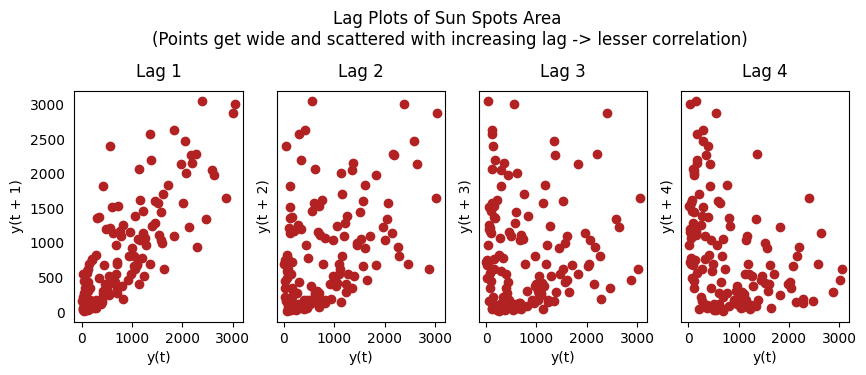

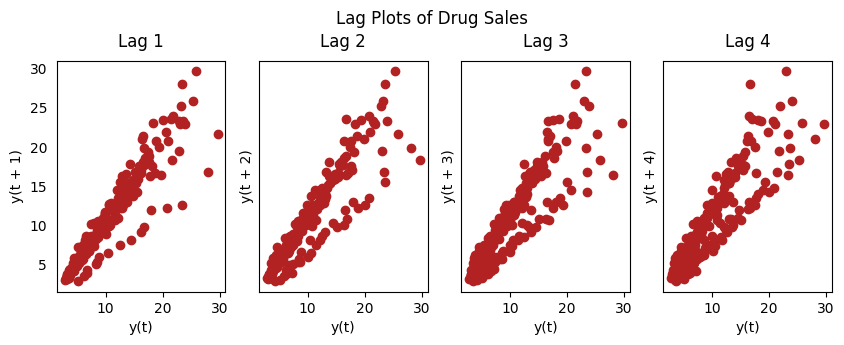

In [21]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Import
ss = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv')
a10 = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(ss.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Sun Spots Area \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(a10.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Drug Sales', y=1.05)    
plt.show()

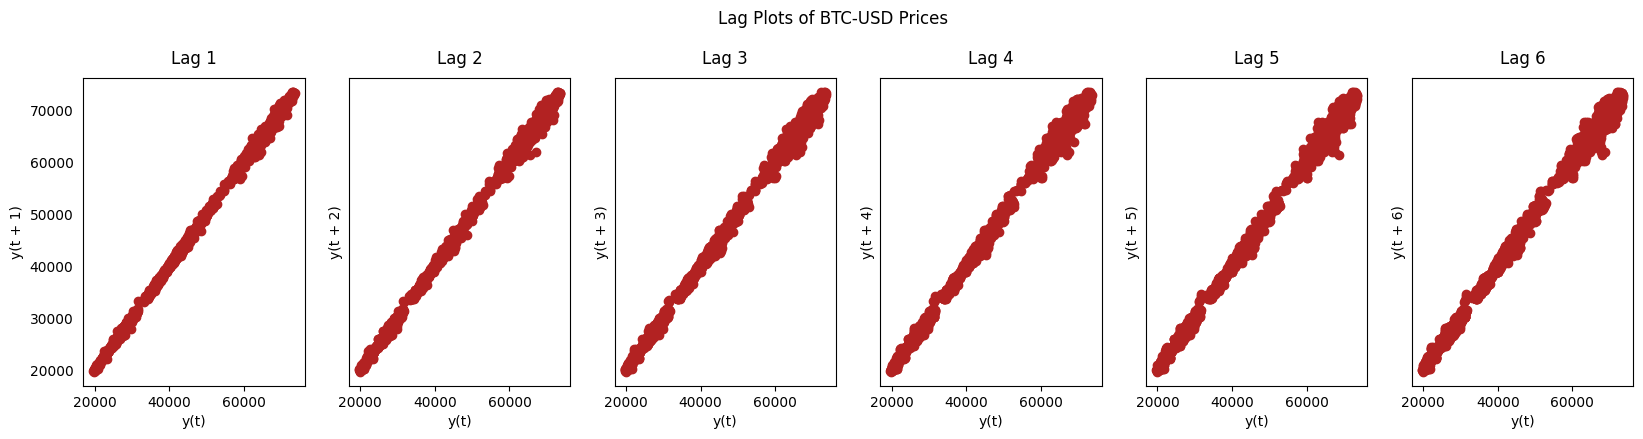

In [22]:
from pandas.plotting import lag_plot

# Ensure the 'value' column is a float if it's not
df['value'] = df['value'].astype(float)

# Plot lag plots for the first 10 lags
num_lags = 6
fig, axes = plt.subplots(1, 6, figsize=(20, 4), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:num_lags]):
    lag_plot(df['value'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of BTC-USD Prices', y=1.05)    
plt.show()


- Strong Autocorrelation: The strong linear relationships across all four lags suggest that the BTC-USD price series has significant autocorrelation, meaning past prices are highly predictive of future prices.
- Persistence: The persistence of this linear pattern across multiple lags indicates that the series exhibits a form of memory, where the influence of past values decays slowly.
- Potential Non-Stationarity: The strong autocorrelation and persistent patterns might suggest that the series could be non-stationary. This aligns with the observations from the ACF plot where the autocorrelation decayed slowly.

## How to estimate the forecastability of a time series?

The more regular and repeatable patterns a time series has, the easier it is to forecast. The ‘Approximate Entropy’ can be used to quantify the regularity and unpredictability of fluctuations in a time series.

**The higher the approximate entropy, the more difficult it is to forecast it.**


Another better alternate is the ‘Sample Entropy’.

Sample Entropy is similar to approximate entropy but is more consistent in estimating the complexity even for smaller time series. 
For example, a random time series with fewer data points can have a lower ‘approximate entropy’ than a more ‘regular’ time series, whereas, a longer random time series will have a higher ‘approximate entropy’.

Sample Entropy handles this problem nicely. 

In [23]:
rand_small = np.random.randint(0, 100, size=36)
rand_big = np.random.randint(0, 100, size=136)

def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

print(ApEn(df.value, m=2, r=0.2*np.std(df.value)))     # 0.651
print(ApEn(rand_small, m=2, r=0.2*np.std(rand_small))) # 0.143
print(ApEn(rand_big, m=2, r=0.2*np.std(rand_big)))     # 0.716

0.020424398189627713
0.0898376940798844
0.6725953850207098


In [32]:
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(df.value, m=2, r=0.2*np.std(df.value)))      # 0.78
print(SampEn(rand_small, m=2, r=0.2*np.std(rand_small)))  # 1.79
print(SampEn(rand_big, m=2, r=0.2*np.std(rand_big)))      # 2.42

0.012041154020011883
1.2237754316221157
1.8437192081587659


## Why and How to smoothen a time series?
Smoothening of a time series may be useful in:
- Reducing the effect of noise in a signal get a fair approximation of the noise-filtered series. The smoothed version of series can be used as a feature to explain the original series itself.
- Visualize the underlying trend better

So how to smoothen a series? Let’s discuss the following methods:

- Take a moving average
- Do a LOESS smoothing (Localized Regression)

Moving average is nothing but the average of a rolling window of defined width. But you must choose the window-width wisely, because, large window-size will over-smooth the series. For example, a window-size equal to the seasonal duration (ex: 12 for a month-wise series), will effectively nullify the seasonal effect.

LOESS, short for ‘LOcalized regrESSion’ fits multiple regressions in the local neighborhood of each point. It is implemented in the statsmodels package, where you can control the degree of smoothing using frac argument which specifies the percentage of data points nearby that should be considered to fit a regression model.

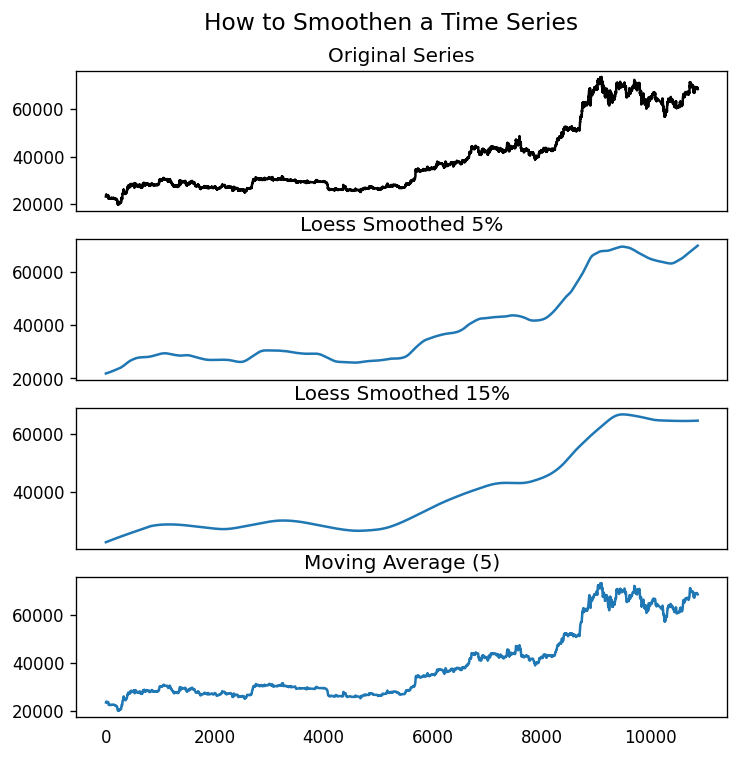

In [127]:
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})


# 1. Moving Average
df_ma = df.value.rolling(5, center=True, closed='both').mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(df.value, np.arange(len(df.value)), frac=0.05)[:, 1], index=df.index, columns=['value'])
df_loess_15 = pd.DataFrame(lowess(df.value, np.arange(len(df.value)), frac=0.15)[:, 1], index=df.index, columns=['value'])

# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
df['value'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['value'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['value'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (5)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

## How to use Granger Causality test to know if one time series is helpful in forecasting another?
Granger causality test is used to determine if one time series will be useful to forecast another.

How does Granger causality test work?

It is based on the idea that if X causes Y, then the forecast of Y based on previous values of Y AND the previous values of X should outperform the forecast of Y based on previous values of Y alone.
So, understand that Granger causality should not be used to test if a lag of Y causes Y. Instead, it is generally used on exogenous (not Y lag) variables only.


It is implemented in the statsmodel package.

It accepts a 2D array with 2 columns as the main argument. The values are in the first column and the predictor (X) is in the second column.

The Null hypothesis is: the series in the second column, does not Granger cause the series in the first. If the P-Values are less than a significance level (0.05) then you reject the null hypothesis and conclude that the said lag of X is indeed useful.

The second argument maxlag says till how many lags of Y should be included in the test.


### Bitcoin price does not follow an autoregressive pattern. The best estimate for the  tn+1 value is the  tn value plus an unpredictable change. Early identification of the absence of this correlation by descriptive analysis avoids unnecessary modeling efforts.

### When a time series with no autocorrelation is available, one should look for exogenous variables capable of helping with the problem. For example, to predict the price of Bitcoin in the short term (hours), exogenous variables such as the market sentiment through the analysis of tweets, impact of the so-called key opinion leaders, analysis of the most relevant news, etc. could be used.